In [145]:
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from uszipcode import ZipcodeSearchEngine
from geopy.geocoders import Nominatim

import pandas as pd
import seaborn.apionly as sns
from datetime import date, datetime
from haversine import haversine

# statistics package
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from random import randint
# packages for mapping
from mpl_toolkits.basemap import Basemap

# packages for interactive graphs
from ipywidgets import widgets, interact
from IPython.display import display
from copy import deepcopy as copy
import time
from geopy.geocoders import Nominatim

from time import sleep
import requests
import time,datetime
import os
%matplotlib inline

In [101]:
findzip = ZipcodeSearchEngine()

In [ ]:
historical_data = pd.read_csv('clean_train_data.csv')

In [ ]:
historical_data.head()

In [ ]:
historical_data.keys()

## Best Revenue from Historical Data

In [ ]:
best_revenue = historical_data.groupby(['hack_license','pickup_date'])['total_amount'].sum()

In [ ]:
np.max(best_revenue.reset_index()['total_amount'])

## Preprocess

In [394]:
historical_data["dropoff_minute"] = pd.to_datetime(historical_data["dropoff_datetime"]).apply(lambda x: x.minute)
historical_data["dropoff_time"] =historical_data["dropoff_hour"] + (historical_data["dropoff_minute"] / 60)

## Reinforcement Model

In [395]:
class TaxiWorld():
    def __init__(self):
        self.waiting_penalty = 5.00
        pass
                
    def getReward(self, row):
        if row['waiting_time']/3600<=2:
            return row['total_amount'] - row['waiting_time']/3600*self.waiting_penalty
        else:
            return row['total_amount']
        
    
    def set_waiting_penalty(self, penalty):
        self.waiting_penalty = penalty
        
    def getState(self):
        print('Current State')
        return self.s
    
    def setState(self, s):
        self.s = s
        
    def getStateSize(self, trip_and_fare):
        return len(trip_and_fare['zip_code'].unique())
    
    def getZipCodes(self, trip_and_fare):
        return self.zip_codes
    
    def getActionSize(self):
        return len(self.actions)

    def nextAction(self, s):
        print('Calculate Next Action based on state')
        
    def check_Q_table(self, s):
        if s not in self.Q:
            self.Q[s] = dict((action, 0.0) for action in self.actions)
            

In [396]:
env = TaxiWorld()

In [406]:
class TaxiRevenue:
    def __init__(self, env, penalty=5.0, Q_table_file_name='saved_Q.json'):
        self.env = env
        self.env.set_waiting_penalty(penalty)
        self.Q = dict()
        self.dropPickMap= dict()
        self.Q_table_file_name = Q_table_file_name
        self.load_Q()
        
    def load_Q(self):
        if os.path.isfile(self.Q_table_file_name):
            with open(self.Q_table_file_name, 'r') as fp:
                self.Q = json.load(fp)
    
    def store_Q(self):
        with open(self.Q_table_file_name, 'w') as fp:
            json.dump(self.Q, fp)
        
    def generate_key(self, row):
        return str(row['pickup_zipcode']) + '_'  + str(row['pickup_weekday']) + '_' + str(row['day_interval']) + '_' + str(row['weather'])
    
    def get_tuples(self, key):
        tuples = key.split('_')
        return {'pickup_zipcode': tuples[0],
                   'pickup_weekday': tuples[1],
                   'day_interval': tuples[2],
                   'weather': tuples[3]}
    
    def get_meantriptime(self, data):
        map=historical_data.groupby(['pickup_zipcode', 'dropoff_zipcode'])['trip_time_in_secs'].mean()
        return map.reset_index()
    
    def isValidPickup(self, taxidata, dropPickMap):
        key=self.generate_key(taxidata)
        if key in dropPickMap:
            return True
        else:
            return False
        
    def generate_dropPickMap(self, data):
        for index,row in data.T.iteritems():
            key = self.generate_key(row)
            if key not in self.dropPickMap:
                self.dropPickMap[key] = []
            if str([str(row['dropoff_zipcode']), row['total_amount']]) not in self.dropPickMap[key]:
                self.dropPickMap[key].append([str(row['dropoff_zipcode']), row['total_amount']])
        return self.dropPickMap
    
    def getDropoff(self, key, dropPickMap):
        posDropoff= dropPickMap[key]
#         print("dropoffs",posDropoff )
        rand=randint(0, len(posDropoff)-1)
        return posDropoff[rand][0], posDropoff[rand][1]
         
    def getDayInterval(self,hour):
        if hour>=6 and hour<12:
            return 0
        elif hour>=12 and hour<18:
            return 1
        elif hour>=18 and hour<24:
            return 2
        else:
            return 3
        
    def getAction(self, taxidata, _Q,dropPickMap, const):
        best_reward=0
        #best_key = 0
        s = self.generate_key(taxidata)
        best_key=s
        #print(taxidata)
        if s in _Q:
            best_reward=_Q[s][0]*_Q[s][1]/const
        
        zipcode=findzip.by_zipcode(taxidata['dropoff_zipcode'])
        temp=taxidata
        possible_pickup=[]
        returns=100
        while not possible_pickup:
            pickup_res = findzip.by_coordinate(zipcode['Latitude'], zipcode['Longitude'], radius=10, returns=returns)
            for i in range(len(pickup_res)):
                temp['pickup_zipcode']=pickup_res[i]['Zipcode']
                #print(temp['pickup_zipcode'])
                if self.isValidPickup(temp, dropPickMap):
                    possible_pickup.append(pickup_res[i]['Zipcode'])

#             print("valid pickup", possible_pickup)
            returns+=10
        
        for key in _Q:
            tuples=self.get_tuples(key)
               
            
            if tuples['pickup_zipcode'] in possible_pickup and tuples['weather']==str(taxidata['weather']) and tuples['pickup_weekday']==str(taxidata['pickup_weekday']) and tuples['day_interval']==str(taxidata['day_interval']):
            
                tempReward=_Q[key][0]*_Q[key][1]/const
                
                if tempReward>best_reward:
                    #print("in temp reward: ",tempReward)
                    #print("in best reward: ",best_reward)
                    best_key=key
                    best_reward= tempReward
                    #print(self.get_tuples(best_key))
                    
        return best_key
    
    def build_Q_table(self, data):
        for index,row in data.T.iteritems():
            key = self.generate_key(row)
            reward = self.env.getReward(row)
            if key not in self.Q:
                self.Q[key] = [reward,1]
            else:
                self.Q[key] = [self.Q[key][0] +reward, self.Q[key][1] + 1]
                
    def greedy(self, s):
        return np.argmax(self.Q[s[0]]) 

    def epsilon_greed(self, epsilon, s):
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_a)
        else:
            return self.greedy(s)
        
    def train(self, trip_and_fare, Q_table_file_name =  'saved_Q.json'):
        self.Q_table_file_name = Q_table_file_name
        self.build_Q_table(trip_and_fare)
        self.store_Q()
        return self.Q
        
    def distance(self, lat1, lon1, lat2, lon2):
        """calculates the Manhattan distance between 2 points
            using their coordinates

        Parameters
        ----------
        lat1: float
            latitude of first point

        lon1: float
            longitude of first point

        lat2: float
            latitude of second point

        lon2: float
            longitude of second point

        Returns
        -------
        d: float
            The Manhattan distance between the two points in kilometers

        """

        d = haversine((lat1, lon1), (lat2, lon1)) + haversine((lat2, lon1), (lat2, lon2))
        return d
    
    def find_distance(self, zip1, zip2):
        zipcode1=findzip.by_zipcode(zip1)
        zipcode2=findzip.by_zipcode(zip2)
        dis=self.distance(zipcode1['Latitude'], zipcode1['Longitude'],zipcode2['Latitude'], zipcode2['Longitude'])
        return dis
    
    
    def test(self, taxidata, _Q, dropPickMap,meanTrip, maxstep=1000):
        # TODO: Add your test routine that exmines learned policy
        #      Using the learned policy, generate the trajectory of 
        curr_dropoff_hour=taxidata['dropoff_time']
        #curr_pickup=taxidata['dropoff_time']
        end_time=curr_dropoff_hour+ 12
        
        itinerary = []
        rewards = []
        
        while curr_dropoff_hour <= end_time:
            
            best_key=self.getAction( taxidata, _Q,dropPickMap, 1000)
            pickup_tuple= self.get_tuples(best_key)
            
            if int(pickup_tuple['pickup_zipcode'])!=taxidata['dropoff_zipcode']:
                dis=self.find_distance(taxidata['dropoff_zipcode'], int(pickup_tuple['pickup_zipcode']))
                curr_dropoff_hour+= dis/taxidata['speed']
                print("roaming time", str(datetime.timedelta(seconds = dis/taxidata['speed']*3600)) )
                
            dropoff, reward=self.getDropoff(best_key, dropPickMap)
                
            print("going from ",pickup_tuple['pickup_zipcode'], " to ",  dropoff, " at ", time.strftime('%H:%M:%S', time.localtime(curr_dropoff_hour*3600)), ' fare cost: ', reward)
            trace = {
                'roaming_time': str(datetime.timedelta(seconds = dis/taxidata['speed']*3600)),
                'start_position': pickup_tuple['pickup_zipcode'],
                'destination': dropoff,
                'current_time': time.strftime('%H:%M:%S', time.localtime(curr_dropoff_hour*3600))
            }
            itinerary.append(trace)
            rewards.append(reward)
            #curr_dropoff=curr_dropoff+meanTrip[meanTrip['pickup_zipcode']]
            #print(pickup_tuple['pickup_zipcode'])
            temptrip = meanTrip[(meanTrip['pickup_zipcode']==int(pickup_tuple['pickup_zipcode'])) & (meanTrip['dropoff_zipcode']==int(dropoff))]
            meanTripTime= temptrip.iloc[0]['trip_time_in_secs']
            #print(meanTripTime)
            
            curr_dropoff_hour=curr_dropoff_hour+meanTripTime/3600
            taxidata['dropoff_zipcode']=int(dropoff)
            taxidata['day_interval']=self.getDayInterval(curr_dropoff_hour)
        print('Done')
        return itinerary, rewards

## Train the Model

In [407]:
taxiRevenue = TaxiRevenue(env, 5.0, 'saved_Q.json')

In [273]:
_Q = taxiRevenue.train(historical_data)

In [399]:
len(_Q)

5496

## Generate Test Data

In [400]:
dropPickMap=taxiRevenue.generate_dropPickMap(historical_data)
meanTrip= taxiRevenue.get_meantriptime(historical_data)

## Test the Model

In [404]:
itinerary, rewards = taxiRevenue.test(historical_data.iloc[14000], _Q, dropPickMap, meanTrip)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


roaming time 0:05:28.031963
going from  10119  to  10022  at  02:23:28 fare: 13.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


roaming time 0:14:23.916822
going from  10119  to  10111  at  02:48:36 fare: 7.0
roaming time 0:11:02.905060
going from  10119  to  10173  at  03:07:15 fare: 5.5
roaming time 0:07:37.748903
going from  10119  to  10022  at  03:20:35 fare: 14.25
roaming time 0:14:23.916822
going from  10119  to  10016  at  03:45:44 fare: 5.75
roaming time 0:06:51.957554
going from  10119  to  10165  at  03:59:26 fare: 6.5
roaming time 0:06:52.714063
going from  10119  to  10111  at  04:13:01 fare: 10.0
roaming time 0:11:02.905060
going from  10119  to  10119  at  04:31:40 fare: 5.9
going from  10119  to  10167  at  04:36:09 fare: 10.0
roaming time 0:09:51.999685
going from  10119  to  10165  at  04:55:08 fare: 10.25
roaming time 0:06:52.714063
going from  10119  to  10020  at  05:08:44 fare: 7.5
roaming time 0:09:56.831187
going from  10119  to  10001  at  05:26:03 fare: 9.5
roaming time 0:04:19.700084
going from  10119  to  10010  at  05:37:10 fare: 7.1
roaming time 0:10:47.539581
going from  10119  to

In [412]:
itinerary[0]

{'current_time': '02:23:28',
 'destination': '10022',
 'roaming_time': '0:05:28.031963',
 'start_position': '10119'}

C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


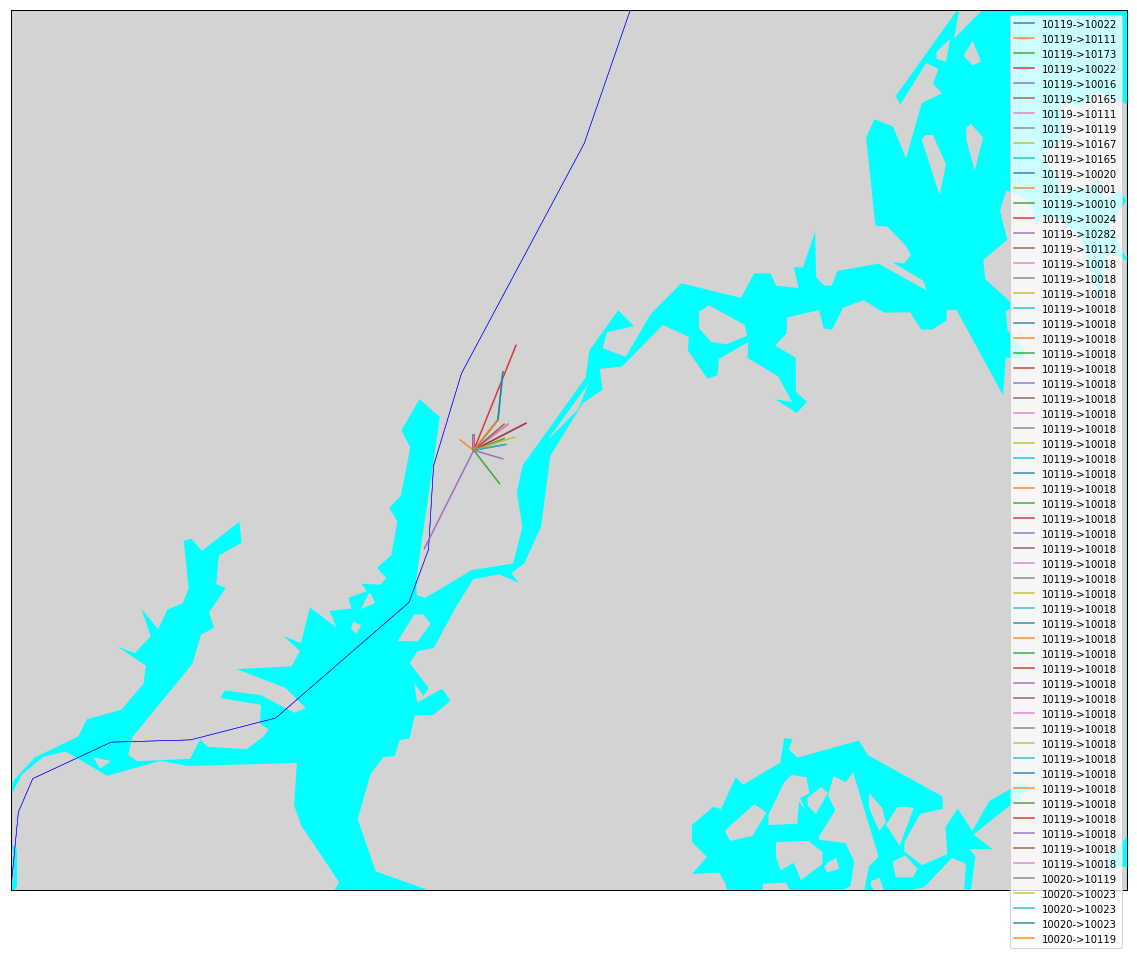

In [436]:
plt.figure(figsize=(20,20))

# Set the limits of the map to the minimum and maximum coordinates
lat_min = 40.6
lat_max = 40.9
lon_min = -74.2
lon_max = -73.7

# Set the center of the map
cent_lat = (lat_min + lat_max) / 2
cent_lon = (lon_min + lon_max) / 2

map = Basemap(llcrnrlon=lon_min, llcrnrlat=lat_min, urcrnrlon=lon_max, urcrnrlat=lat_max, resolution='h', projection='tmerc', lat_0 = cent_lat, lon_0 = cent_lon, area_thresh = 0.1)

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='lightgray', lake_color='aqua')
map.drawcountries(linewidth=2)
map.drawstates(color='b')

for trace in itinerary:
    long = []
    lat = []
    start_position = trace['start_position']
    res = findzip.by_zipcode(start_position)
    long.append(res['Longitude'])
    lat.append(res['Latitude'])
    
    destination = trace['destination']
    res = findzip.by_zipcode(destination)
    long.append(res['Longitude'])
    lat.append(res['Latitude'])
    x, y = map(long, lat)
    plt.plot(x, y, '-', label=str(start_position)+'->'+str(destination), markersize=10, alpha=0.9)

# plt.show()
plt.legend()

## Merge Train Data

In [277]:
train_data1 = pd.read_csv('clean_data.csv')
train_data2 = pd.read_csv('clean_data_2.csv')
train_data3 = pd.read_csv('clean_data_3.csv')
train_data4 = pd.read_csv('clean_data_4.csv')
train_data5 = pd.read_csv('clean_data_5.csv')
frames = [train_data1, train_data2, train_data3, train_data4, train_data5]
result = pd.concat(frames)
result.to_csv('clean_train_data.csv', index=False)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [278]:
result.shape

(2905906, 38)